# Adam local optimiser

_Adam_ (from "adaptive moment estimation") is a local gradient-descent-with-momentum method, similar to AdaGrad and RMSProp. It uses a fixed step size, but maintains two _momentum_ parameters which are continuously updated.

Very clear psuedocode is given in [this paper](https://doi.org/10.48550/arXiv.1412.6980) (Algorithm 1).

## Example 1: finding the bottom of a parabolic valley

As a first test we optimise on a parabola, centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    ax.set_aspect('equal')
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

We choose a starting point and make a plot:

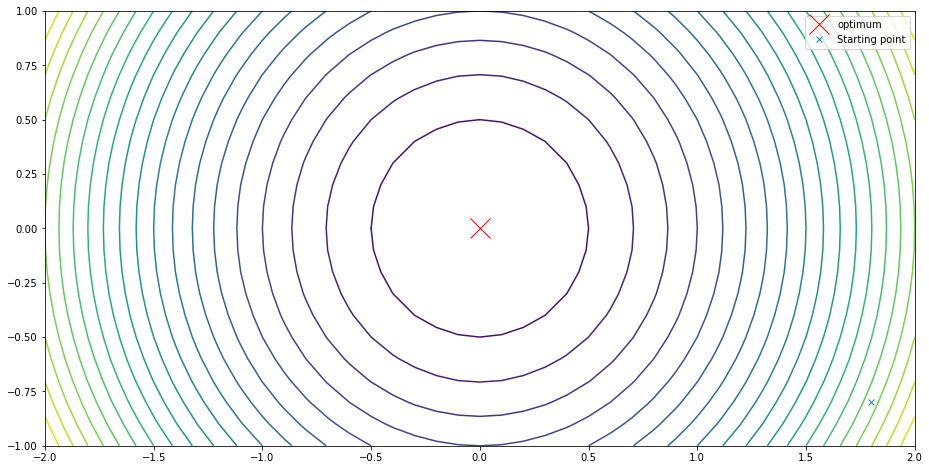

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now we create an optimiser and use the ask-and-tell interface to let it walk a few steps.
The step size will be set using the `sigma0` parameter:

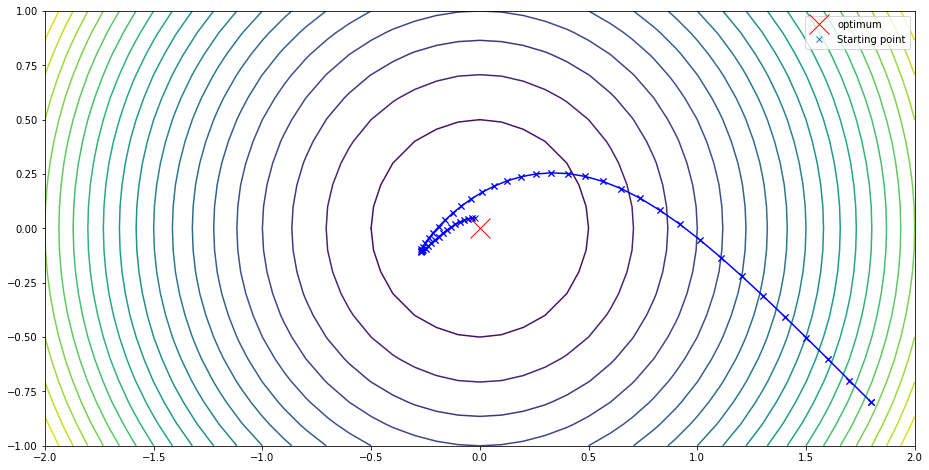

In [4]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.Adam(x0, 0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

We can immediately see the "momentum" in effect: the optimiser quickly overshoots and travels up the gradient, before starting down it again.

If we like, we can be cheeky and make the step size much too large:

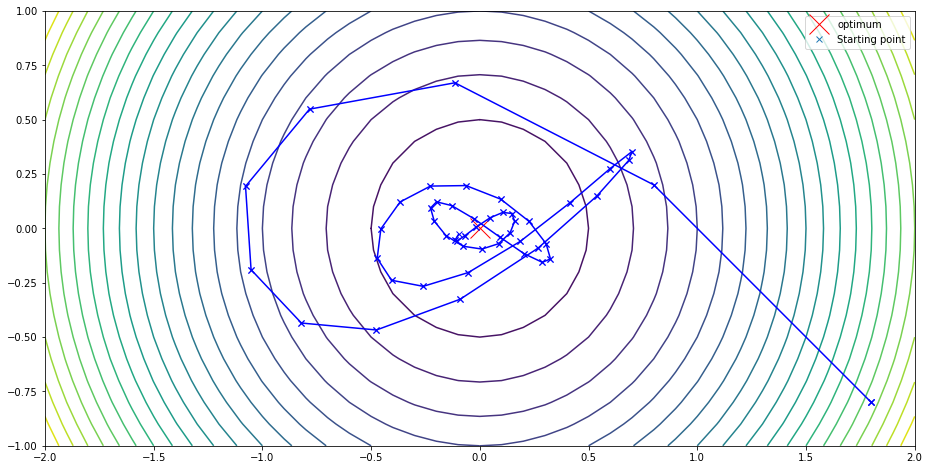

In [5]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.Adam(x0, 1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

Wheeeeeee!

Despite our bad initial settings, the method quite quickly recovers and starts moving towards the optimum. Note how the momentum decreases over time.

## Example 2: Maximising a difficult LogPDF

We can also try this method on the ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).

Because this is a LogPDF and our optimiser minimises, we need to wrap it in a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError). Note that this is only necessary for manual ask-and-tell: if we use the OptimiserController it does this bit for us!

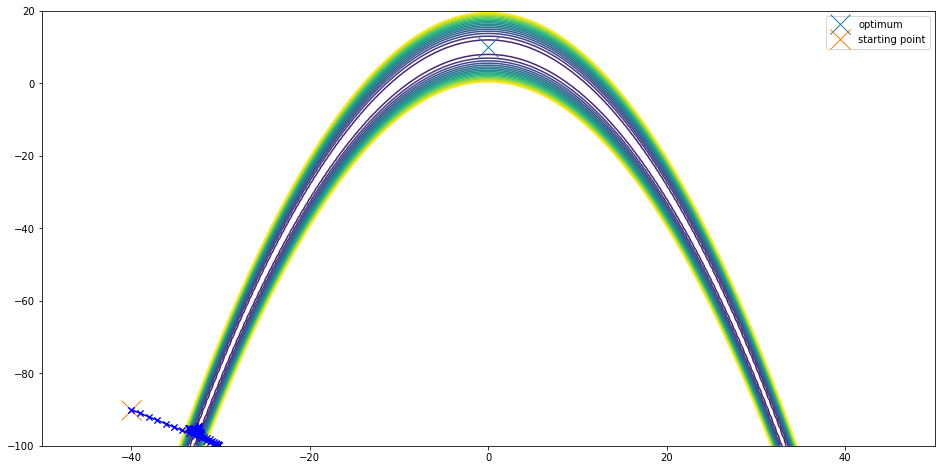

In [6]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.Adam(x0, 1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(4000):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

The method performs a bit better than other methods like fixed step-size gradient descent, but still gets stuck pretty quickly.

We can try to remedy this by trying some different step sizes:

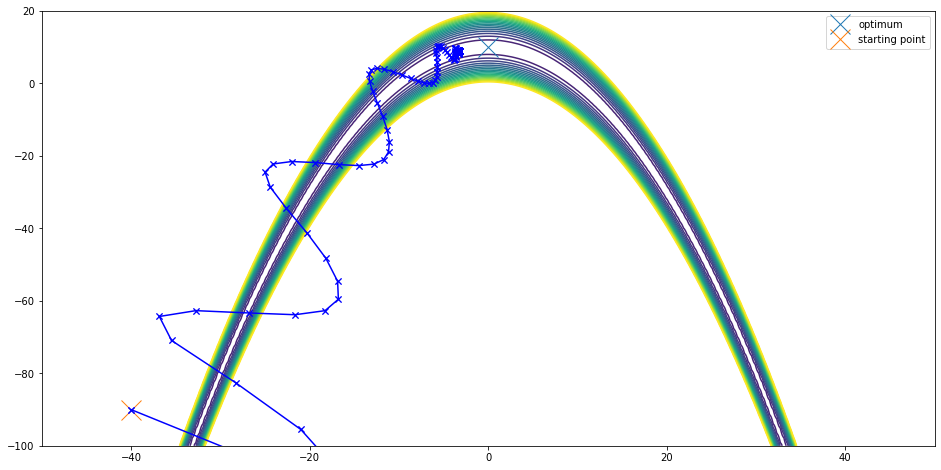

In [7]:
def try_again(sigma0):
    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-50, 50)
    plt.ylim(-100, 20)
    plt.contour(X, Y, Z, levels=levels)
    plt.plot(0, 10, 'x', markersize=20, label='optimum')
    plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

    opt = pints.Adam(x0, sigma0)
    e = pints.SequentialEvaluator(error.evaluateS1)

    x1 = x0
    for i in range(400):
        xs = opt.ask()
        fs = e.evaluate(xs)
        opt.tell(fs)

        x2 = xs[0]
        plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
        x1 = x2

    plt.legend()
    plt.show()
    
try_again(20)

That seems to have worked pretty well! Are bigger step sizes the answer?

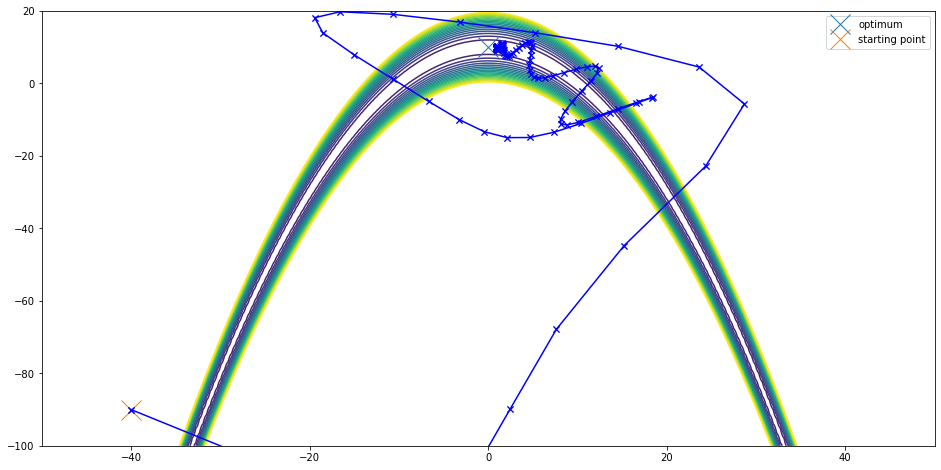

In [8]:
try_again(30)

This looks _very_ messy, but does get near the optimum! Maybe if we pick a step size somewhere in between?

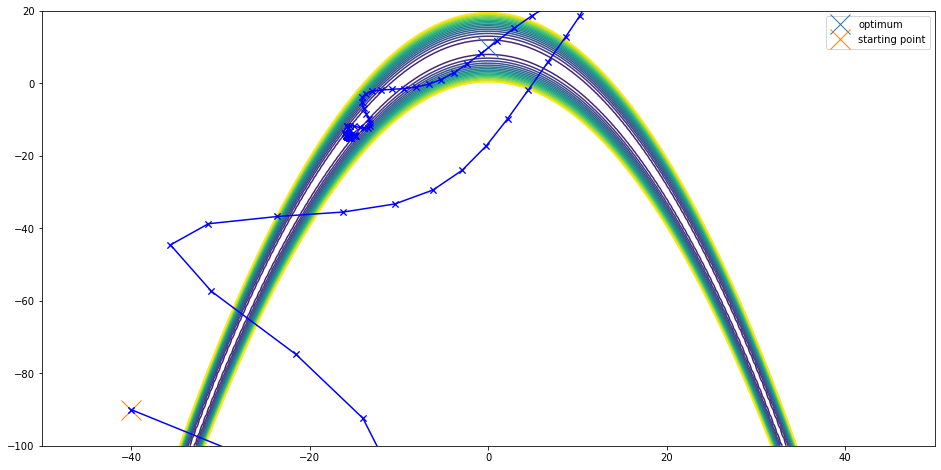

In [9]:
try_again(25)

Nope! It appears we were just a bit lucky, and this problem is too hard for this method.

## Example 3: A noisy time-series problem

Finally, we apply this method to a noisy time series problem:

In [10]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    sigma0=0.01,
    method=pints.Adam
)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Adam
Running in sequential mode.
Iter. Eval. Best      Current   b1        b2        Time m:s
0     1      1.92e+07  1.92e+07  0.9       0.999      0:00.0
1     2      4926527   4926527   0.81      0.998001   0:00.0
2     3      4926527   1.28e+07  0.729     0.997003   0:00.0
3     4      4926527   1.69e+07  0.6561    0.996006   0:00.0
20    21     1221264   5464337   0.109419  0.979      0:00.0
40    41     1221264   1607555   0.0133    0.96       0:00.0
60    61     1208115   1295572   0.00162   0.941      0:00.0
80    81     1198737   1199878   0.000197  0.922      0:00.0
100   101    1187750   1188368   2.39e-05  0.904      0:00.0
120   121    1178302   1178302   2.91e-06  0.886      0:00.0
140   141    1169479   1169479   3.53e-07  0.868428   0:00.0
160   161    1160725   1160725   4.3e-08   0.851      0:00.0
180   181    1152018   1152018   5.22e-09  0.834      0:00.0
200   201    1143361   1143361   6.35e-10  0.818      0:00.0
220   221    1134754 

3200  3201   327056.4  356164    3.39e-147  0.0407     0:00.4
3220  3221   321708.1  339388.5  4.12e-148  0.0399     0:00.4
3240  3241   321708.1  326159.8  5.01e-149  0.0391     0:00.4
3260  3261   316097.9  330844    6.09e-150  0.0383     0:00.4
3280  3281   312065.1  312065.1  7.41e-151  0.0375     0:00.4
3300  3301   311185.3  345478.7  9.01e-152  0.0368     0:00.4
3320  3321   311185.3  315559.4  1.09e-152  0.0361     0:00.4
3340  3341   311185.3  356809.3  1.33e-153  0.0353     0:00.4
3360  3361   301294.4  306945.1  1.62e-154  0.0346     0:00.4
3380  3381   301294.4  326143.7  1.97e-155  0.034      0:00.4
3400  3401   296454.7  325094.3  2.39e-156  0.0333     0:00.4
3420  3421   296454.7  299096.7  2.91e-157  0.0326     0:00.4
3440  3441   290974    292645.1  3.54e-158  0.032      0:00.4
3460  3461   290974    308050.9  4.3e-159  0.0313     0:00.4
3480  3481   286448    289273.3  5.23e-160  0.0307     0:00.4
3500  3501   283504    305601.1  6.35e-161  0.0301     0:00.4
3520  352

6380  6381   109982.8  140057.3  1.05e-292  0.00169    0:00.8
6400  6401   109982.8  127752.3  1.28e-293  0.00165    0:00.8
6420  6421   109982.8  143861.3  1.55e-294  0.00162    0:00.8
6440  6441   109982.8  116723.8  1.89e-295  0.00159    0:00.8
6460  6461   109982.8  163388.9  2.3e-296  0.00156    0:00.8
6480  6481   108390.6  124635.8  2.79e-297  0.00153    0:00.8
6500  6501   108390.6  130979.3  3.39e-298  0.0015     0:00.8
6520  6521   107908.3  108072.7  4.12e-299  0.00147    0:00.8
6540  6541   107908.3  235807.9  5.01e-300  0.00144    0:00.8
6560  6561   107765.2  156691.1  6.1e-301  0.00141    0:00.8
6580  6581   107435.8  120439.2  7.41e-302  0.00138    0:00.8
6600  6601   107435.8  140070    9.01e-303  0.00135    0:00.8
6620  6621   107435.8  122174.5  1.1e-303  0.00133    0:00.8
6640  6641   107435.8  150884.9  1.33e-304  0.0013     0:00.8
6660  6661   107435.8  109236.1  1.62e-305  0.00128    0:00.8
6680  6681   107435.8  205661.8  1.97e-306  0.00125    0:00.8
6700  6701 

This works, but it takes nearly 9000 evaluations! Note also how we had to choose our step size quite carefully.